# Base Notebook

Contains Data Preprocessing, Augmentation, and Basic Model Templates

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import sys

## Contents

### Directories

In [6]:
# go to parent directory
os.chdir("..")
import paths

REPO_DIR = paths.get_repo_path()
ROOT_DIR = REPO_DIR / "Stanford Dogs"
DATA_BASE_PATH = paths.get_data_path() / "stanford-dogs-dataset"
DATA_PATH = DATA_BASE_PATH / "splited-data"

TRAIN_PATH = DATA_PATH / "train"
TEST_PATH = DATA_PATH / "test"

# set path to repo_dir
os.chdir(REPO_DIR)

## Data

### Variables

In [103]:
RANDOM_SEED = 42
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

VALIDATION_SPLIT = 0.2

BATCH_SIZE = 64

CLASS_NAMES = sorted([img_cls for img_cls in  os.listdir(TRAIN_PATH) if img_cls != ".DS_Store"])
NUM_CLASSES = len(CLASS_NAMES)

# MODEL
MODEL_PATH = ROOT_DIR / "model"
LOG_PATH = ROOT_DIR / "log"



In [94]:
tf.random.set_seed(RANDOM_SEED)

### Data Augmentation

In [87]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1./255,
    
    horizontal_flip=True,
    
    rotation_range=20,
    
    height_shift_range=0.1,       # No need to shift the image
    width_shift_range=0.1,
    zoom_range=0.1,
    
    shear_range=0.1,              # Seems to be useful
    
    validation_split=VALIDATION_SPLIT,
)

val_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    )

test_generator = ImageDataGenerator(
    rescale=1./255,
)

In [88]:
train_images = train_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    
    shuffle=True,
    seed=42,
    
    subset='training',
)

val_images = val_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    
    shuffle=True,
    seed=42,
    
    subset='validation'
)


test_images = test_generator.flow_from_directory(
    TEST_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    
    batch_size=BATCH_SIZE,
    
    shuffle=True,
    seed=42,
)

NUM_TRAIN_IMAGES = len(train_images.filenames)
NUM_VAL_IMAGES = len(val_images.filenames)
NUM_TEST_IMAGES = len(test_images.filenames)

Found 12369 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.
Found 5186 images belonging to 120 classes.


### LOADING DATA

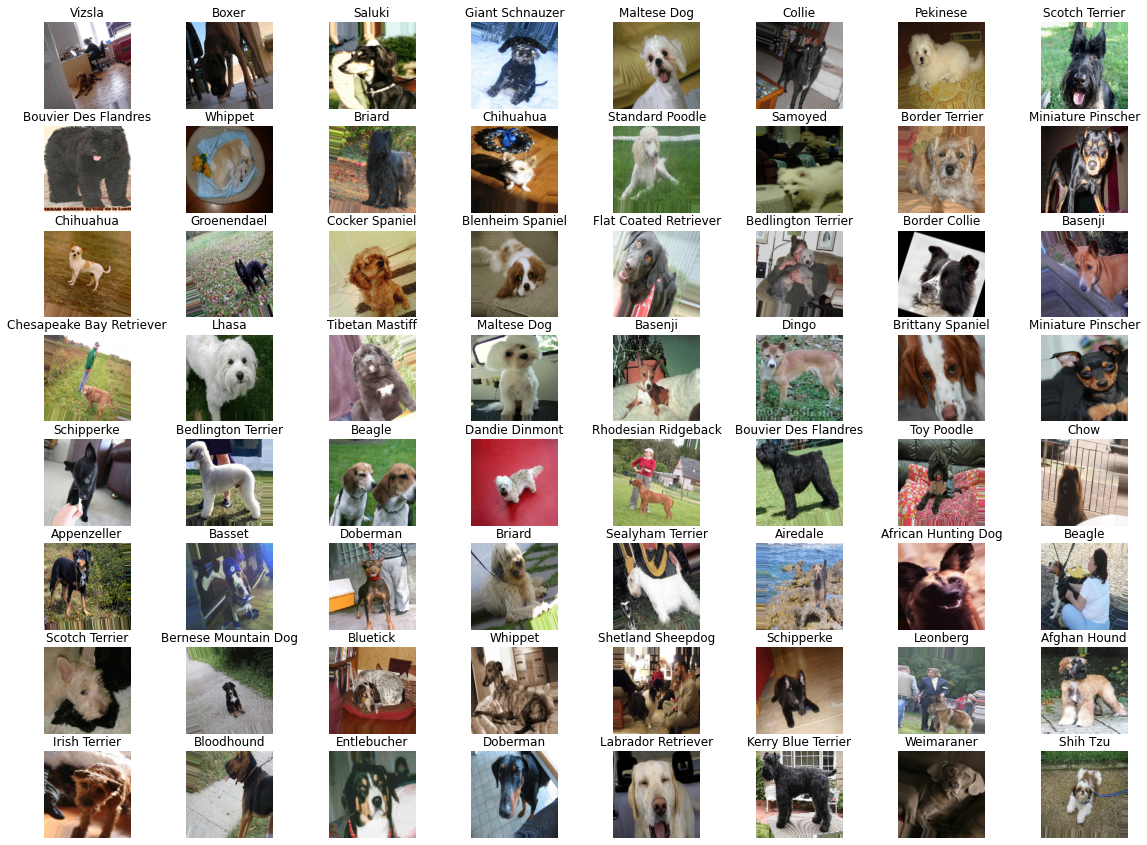

In [89]:
num_rows = 8
num_cols = 8

plt.figure(figsize=(20, 15))

images, labels = train_images.next()
for i in range(num_cols * num_rows):
    plt.subplot(num_cols, num_rows, i + 1)
    plt.imshow(images[i])
    plt.title(CLASS_NAMES[labels[i].argmax()])
    plt.axis('off')

plt.show()

## Model

In [137]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Rescaling, Input, Add, Activation, BatchNormalization, AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score


### Valribles

In [98]:
INPUT_SHAPE = train_images.next()[0][0].shape
TRAIN_MODELS = True
# TRAIN_MODELS = False

In [ ]:
models_performance = {}


### Useful functions ###

In [99]:
# ploting the model training history
def plot_model_performance(history, figsize=(10, 10)):
    preformance = {key: val for key, val in history.history.items() if "loss" not in key}
    losses = {key: val for key, val in history.history.items() if "loss" in key}
    
    plt.figure(figsize=figsize)
    plt.title('Model Performance')
    for key, val in preformance.items():
        plt.plot(val, label=key)
    plt.legend(preformance.keys())
    plt.xlabel('Epoch')
    
    plt.figure(figsize=figsize)
    plt.title('Model Losses')
    for key, val in losses.items():
        plt.plot(val, label=key)
    plt.legend(losses.keys())
    plt.xlabel('Epoch')
    
    plt.show()


def confusion_matrix_plot(y_test, y_pred, figsize=(12, 10), labels=None):
    plt.figure(figsize=figsize)
    cm = confusion_matrix(y_test, y_pred)
    cm_plot = sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu")
    cm_plot.set_title('Confusion Matrix')
    cm_plot.set_xlabel('Predicted Label')
    cm_plot.set_ylabel('True Label')
    if labels:
        cm_plot.set_xticklabels(labels)
        cm_plot.set_yticklabels(labels)
        
    plt.show()
    
def classification_report_plot(y_test, y_pred, figsize=(12, 10), labels=None):
    plt.figure(figsize=figsize)
    cr = classification_report(y_test, y_pred, output_dict=True)
    if labels:
        cr = classification_report(y_test, y_pred, output_dict=True, target_names=labels)
    cr_heatmap = sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, cmap="YlGnBu", fmt='.2f')
    cr_heatmap.set_title('Classification Report')
    cr_heatmap.set_xlabel('Metrics')
    cr_heatmap.set_ylabel('Classes')
        
    plt.show()
    

### MODELS

#### MODEL ARCHITECTURE

In [142]:
from tensorflow.keras.models import Sequential

model_name = "Base_Model"
weight_decay = 10e-5
LEARNING_RATE = 1e-4
# weight_decay = 0

def final_model(input_shape: int, num_classes: int, base_filters: int=32, dropout_rate: float=0.2,):
    model = Sequential()
    
    model.add(Rescaling(1./255, input_shape=input_shape))
    
    #Convolutional layers
    #Conv Block 1 with l2 regularization
    model.add(Conv2D(base_filters, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(base_filters, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    
    #Conv Block 2
    dropout_rate+=0.15
    model.add(Conv2D(base_filters*2, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(base_filters*2, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    
    #Conv Block 3
    dropout_rate+=0.15
    model.add(Conv2D(base_filters*4, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(base_filters*4, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(base_filters*4, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    
    # Flatten
    model.add(Flatten())
    
    dropout_rate+=0.1
    model.add(Dense(128, kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Dropout(dropout_rate))

    # dropout_rate+=0.1
    # model.add(Dense(32, kernel_regularizer=l2(weight_decay)))
    # model.add(BatchNormalization())
    # model.add(Activation("relu"))
    # model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=Adam(lr=LEARNING_RATE), 
        metrics=[
            'accuracy', 
            # tf.keras.metrics.TopKCategoricalAccuracy(k=5),
            'top_k_categorical_accuracy',
            ],
        )
    
    return model


In [143]:
model = final_model(INPUT_SHAPE, NUM_CLASSES, base_filters=64, dropout_rate=0.1)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_48 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                                
                                                                 
 activation_48 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 conv2d_43 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_49 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                     

/Users/vineetmahajan/.pyenv/versions/miniforge3-4.10.3-10/envs/env_tf/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### Model Training

In [144]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger

monitor_metric = 'val_loss'

# Early stopping
es = EarlyStopping(
        monitor=monitor_metric,
        patience=5,
        mode = "auto",
        verbose=1,
)

# Learning rate scheduler
def step_decay(epoch):
    initial_lr = 1e-3
    k = 0.1
    lr = initial_lr * np.exp(-k*epoch)
    return lr

lrd = LearningRateScheduler(step_decay)

# Model Checkpoint
mdl_check = ModelCheckpoint(
        MODEL_PATH / f"{model_name}.h5",
        monitor=monitor_metric,
        save_best_only=True,
        mode='auto',
        verbose=1,
)
        
# CSV Logger
csv_logger = CSVLogger(
        LOG_PATH / f"{model_name}.csv",
        append=False,
)


callbacks = [
        es, 
        lrd,
        mdl_check, 
        csv_logger,
    ]

In [146]:
train_model = not (os.path.exists(MODEL_PATH / f"{model_name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=75, 
                        callbacks=callbacks,                        
)

In [ ]:
if train_model:
    plot_model_performance(history)

In [ ]:
if train_model:
    model.evaluate(test_images)